In [ ]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance
from statsmodels.distributions.empirical_distribution import ECDF
import datetime
import seaborn as sns
import math
import random
from numpy import exp
import pyreadstat

from scipy.optimize import curve_fit

import json

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'

In [ ]:
font = {'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [25]:
res='results_mobility/'

# Datasets Reading

### MiD Data 2017
Mobilität in Deutschland

The loading of this data set requires you to have acquired the MiD 2017 data, which is not public and must be requested via https://daten.clearingstelle-verkehr.de/order-form.html . Only execute these code blocks in case you acquired the data set.

In [4]:
# data reading
'''
wegkm: wegelänge, path length
hvm: hauptverkehrsmittel, main mode of transport
hvm_diff2: hauptverkehrsmittel (stärker differenziert), more differentiated

'''
df_MiD=pd.read_csv('../data/MiD2017_Wege.csv',decimal=',',sep=';',usecols=['wegkm','hvm','hvm_diff2','W_ZWECK','ST_JAHR','ST_MONAT'])
#exclude unwanted lines with "unknown" distance value et al
df_MiD=df_MiD[df_MiD.wegkm.isin([9994,9999,70703]) == False]
df_MiD.head(2)

,ST_MONAT,ST_JAHR,W_ZWECK,wegkm,hvm,hvm_diff2
0,3,2017,1,21.85,4,9
1,3,2017,5,0.39,1,1


In [5]:
# Different transport modes extraction
df_MiD_public=df_MiD[df_MiD.hvm.isin([5]) == True] #public
# Public Transport w/o long distance vehicles,short range
df_MiD_SRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([19,20,21,22,23])==False] 
# long range
df_MiD_LRpublic=df_MiD_public[df_MiD_public.hvm_diff2.isin([20,21,22,23])==True] 

### NHTS17 data
American travel and trip data

The data is public and can be acquired via https://nhts.ornl.gov/downloads The relevant file is `trippub.csv`.

In [2]:
# data reading
# TRPMILES: Trip distance in miles, derived from route geometry returned
# TRPTRANS: Trip Mode, derived 
# WHYTRP1S: Trip purpose summary
df_Nhts=pd.read_csv('data/trippub_2017NHTS.csv',decimal='.',sep=',',usecols=["TRPMILES", "TRPTRANS","WHYTRP1S"])
df_Nhts.head(2)

,TRPMILES,TRPTRANS,WHYTRP1S
0,5.244,3,20
1,5.149,3,1


In [3]:
# Different transport modes extraction and unit conversion to Km
# long distance public transport
# 14 City-to-city bus (Greyhound, Megabus), 19 Airplane, 20 Boat/ferry/water taxi
df_Nhts_LRpublic=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([14,19,20])==True]*1.60934  

# Modelling long-distance public trips
In this section we present the tools we used to derive the best-fitting amplified power-law process as well as the best-fitting truncated power-law for given emperical data-set

The parameters and values of the best-fitting processes are stored in a file. As the modelling procedure contains a parameter search this may take time to execute. For convenience, we also provided the `.pkl` files containing the results we obtained, allowing this section to be skipped.

## Error function

In order to determine whether a given CCDF describes the CCDF of our emperical data well, we use the following error function.
For a series of sample points $S$, it calculates the error as $\frac{1}{2} \sum_{x_i \in S} \dfrac{|f(x_i)-g(x_i)|}{ f(x_i)+g(x_i)}$.

In [4]:
''' Error function
Compute the distance between two 1D distributions.
Can be different length of these two distributions

d1,d2: the distribution, should be the type of List or pd.Series
'''

def custom_distance(d1,d2):
    if type(d1)==np.ndarray or type(d1)==list or type(d1)==pd.Series:
        if type(d2)==np.ndarray or type(d2)==list or type(d2)==pd.Series:
            # find the overlap of two distributions
            min_d=max(min(d1),min(d2))
            max_d=min(max(d1),max(d2))
        else:
            print('Wrong: Data type is not ndarray, List or pd.Series')
    else:
        print('Wrong: Data type is not ndarray, List or pd.Series')
    # re-sampling
    # given the point x value and whole data, calculate the point of y value in CCDF
    sorted_d1 = np.sort(d1)
    linspaced1 = np.linspace(0, 1, len(sorted_d1), endpoint=False)
    y_d1=1-linspaced1
    
    sorted_d2 = np.sort(d2)
    linspaced2 = np.linspace(0, 1, len(sorted_d2), endpoint=False)
    y_d2=1-linspaced2
    
    distance=0
    # number of linearly spaced numbers
    num=1000
    a = np.linspace(min_d,max_d,num)  
    
    for i in a:
        b1=np.interp(i, sorted_d1,y_d1)
        b2=np.interp(i, sorted_d2,y_d2)
        
        e=abs(b1-b2)/((b1+b2)/2)
        
        distance=distance+e
    return distance/num


## Finding the best-fitting amplified power-law model for a given data-set
Here we derive the parameters of the amplified power-law process that best describes the emperical data-set.
The values of the best-fitting process are then stored for later use.

In [10]:
"""
Since there are two datasets MiD and NHTS, 
the comment about settings in this block relate to the conversion between these two datasets

Currently, it shows the perfomance on MiD dataset,
if you want to see another dataset, please uncomment them accordingly.
"""

# MiD long distance
#df_vec=df_MiD_LRpublic['wegkm'].copy() # Long distance in MiD 2017
#min_distance=100
#max_distance=900
#maxdistance=900

# NHTS long distance
df_vec=df_Nhts_LRpublic.copy() # Long distance in NHTS17
# filter the emperical data to only consider trips of the following range
min_distance=300
max_distance=5000
# limits the distance of trips generated by the amplified power-law process
# set to correspond roughly to the largest distance on continental U.S.
maxdistance=5000

# The CCDF of our model is not created analytically. Instead we simulate a series of trips
# following the distance-amplified power-law process. The resulting distances are collected and
# a CCDF is created.
# This parameter determines the umber of trips to be generated for each parameter combination. 
# Larger values can take long to compute.
sampleNumber_model=10000

df_vec=df_vec[df_vec.between(min_distance,max_distance)]

In [14]:
"""
Range of parameter values to find the best fit.
"""

# definition/settings for datasets
# ----settings of parameters for MiD
# eps_range=np.arange(0.9,1.8,0.02)
# p_range=np.arange(0.7, 0.99, 0.01)
# alp_range=np.arange(1.02,1.3,0.02)

# ----settings of parameters for NHTS
eps_range=np.arange(0.8,1.8,0.01) #note that (1+eps) is equal to amplification parameter C described in the paper
p_range=np.arange(0.7,0.99, 0.01)
alp_range=np.arange(1.02,1.6,0.05)

# create an array of all parameter combinations to consider
# error is initialized to 0 and will be replaced later on
err=[0]
combinable=[[eps,p,alp,0,0] for eps in eps_range for p in p_range for alp in alp_range for error in err] #list

In [ ]:
%%time

''' 
Find the best-fitting parameter values for a distance-amplified power-law process
that follows the rules specified in the two previous blocks.
'''
tmp_max=(maxdistance/2) # half of the maximum allowed distance for any trip

for i in range(len(combinable)):
    if i%100==0:
        print("Samples completed: " + i)
        print ("Current date and time : ",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    eps=combinable[i][0]
    p=combinable[i][1]
    alp=combinable[i][2]
    error=combinable[i][3]
    all_dist=combinable[i][4]
    dist=[]
    
    # simulate each trip
    for n in range(sampleNumber_model):
        distance=9999999
        
        # first determine the maximum distance the trip can have
        # we assume that the country (U.S and Germany) can be described by a circular shape of radius tmp_max
        
        # the trip is assigned a starting location inside the circle (selected uniformly at random)
        # the max_distance this trips is allowed to have is then the largest distance between the trips origin
        # and the edge of the circle.

        # instead of simulating this process for each trip, we consider the resulting distribution of these max_distance
        # values and sample from it as follows
        tmp=np.random.uniform(0,1)
        max_distance=math.sqrt(1-tmp)*tmp_max+tmp_max
        
        # as long as the trip length exceeds the allowed maximum, draw a new distance
        while(distance>=max_distance or distance<min_distance):
            
            # draw sp from the power-law distribution with parameter alp
            sp=np.random.uniform(0,1,1)**(-1/(alp-1))
            
            #amplification part
            #start with drawn power-law distance
            distance=sp[0]
            #compute how many times an amplifications occurs
            number=np.random.geometric(1-p,1)[0]
            #amplify by factor (1+eps) each time
            distance=((1+eps)**(number-1))*distance

        dist.append(distance)
      
    combinable[i][4]=dist
    # error computation
    error=custom_distance(dist,df_vec)
    combinable[i][3]=error


In [30]:
# Convert results to dataframe and save
df_com=pd.DataFrame(combinable)
com=df_com.values

# The lowest error and corresponding parameters to get the optimal error
idx_best=com[:,3].argmin()
eps2 = com[idx_best,0]
p2 = com[idx_best,1]
alp2 = com[idx_best,2]
dist2= com[idx_best,4]

(36000, 5)


In [31]:
'''
Save only the best results to avoid excessive file storage requirements

Due to the random element in the modeling,
you can also find the stored results we used in the folder 'result_mobility'

In case MiD data was used, change the comments accordingly.

'''
# the results contain the value of eps,p, alpha errors and list of simulated trip length
opt_modelling=pd.DataFrame(combinable[idx_best])

#opt_modelling.to_pickle(res+'Best results of LR Modelling in MiD17.pkl')
opt_modelling.to_pickle(res+'Best results of LR Modelling in NHTS17.pkl')

## Finding the best-fitting truncated power-law process for a given data set

The truncated powerlaw given by parameters $\alpha$ and $\gamma$ is given by the density function $f(x) = C \cdot x^{-\alpha} \cdot e^{-x/\gamma}$. The constant $C > 0$ is used for normalization.

As we consider only data starting from a minimum distance, e.g., $100$ kilometers, we choose $C>0$ such that $\int_{100}^{\infty} f(x) dx = 1$.
To simplify the calculation, we instead approximate this integral as a sum $\sum_{i=100}^{2000} f(i)$, where we chose the upper limit large enough to only cause negigable inaccuracies.
The index values these sum runs over are given via the list `Ds` in our code.

In order to find the parameters of a truncated powerlaw distribution that best describes a data set, we consider a range of $\alpha$ and $\gamma$ values.
For any fixed combination of $\alpha$ and $\gamma$, first, $C$ is computed and then
the approximated CCDF $F(x) = \sum_{d \in Ds} f(d)$ is calculated.

In [20]:
'''Normalize data before calculating errors to make differences more meaningful
since the data for error calculation may have large gaps regarding values itself, 
but we need to focus on the trend of dataset as well
''' 
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [22]:
'''
Density function of the truncated power-law distribution
'''
def funcD(C,d,alpha,gamma):
    fD=C/d**alpha*(math.exp(-d/gamma))
    return fD

# This function is used as a helper function when computing C
def funcD_noC(d,alpha,gamma):
    fD_noC=1/d**alpha*(math.exp(-d/gamma))
    return fD_noC

In [11]:
'''
MiD 2017
uncomment when working with the MiD data set
'''
#df_vec=df_MiD_LRpublic['wegkm'].copy() # Long distance in MiD 2017
#min_distance=100
#max_distance=2000
#df_vec=df_vec[df_vec.between(min_distance,max_distance)]

# limitations of searching the truncated power-law
#alphas=np.arange(1.02, 1.051,0.005) 
#gammas=np.arange(200, 1001,20)
#Ds=np.arange(100,2001,1) #distance trips setted

In [16]:
'''
 NHTS 2017
'''
df_vec=df_Nhts_LRpublic.copy() # Long distance in NHTS 2017
# Only consider emperical data that lies in a certain km range
min_distance=300
max_distance=5000
df_vec=df_vec[df_vec.between(min_distance,max_distance)]

# limitations of searching parameters for the truncated power-law
alphas=[1.02,1.12]
gammas=np.arange(400, 5001,50)
Ds=np.arange(300,12001,10) #distance trips setted


In [21]:
%%time

'''
Finding optimal combination of parameters for truncated power law fitting
'''

results=[] # results contain alpha, gamma,C, error between the truncated power-law and emiprical data

# for each combination of alpha and gamma
for alpha in alphas:
    for gamma in gammas:
        
        # first compute the normalization constant C
        temp=0
        for d in Ds:
            temp+=funcD_noC(d,alpha,gamma)
        C=1/temp
        
        #compute the (approximate) CCDF F(d) of a truncated power-law
        #at several sample points given by Ds
        Fd=[0]*len(Ds)
        for idx,d in enumerate(Ds):
            for i in Ds[Ds>=d]:
                Fd[idx]+=funcD(C,i,alpha,gamma)
        
        empircal_data=df_vec.tolist()
        # normalize the empircal data to make it can be compared with Fd, since the value of Fd always smaller than 1
        normalized_empircal=NormalizeData(empircal_data).tolist()
        error=custom_distance(Fd,normalized_empircal)
        
        results.append([alpha,gamma,C,error])

CPU times: total: 4min 39s
Wall time: 4min 39s


In [26]:
'''
Save the optimal truncated power-law fitting results
Please uncomment the MiD part when needed
'''
#convert results to dataframe
results_truncated=pd.DataFrame(results, columns =['alpha', 'gamma', 'C','error']) 
# save the optimal results
opt_truncated=results_truncated.iloc[results_truncated.error.argmin(),:]
# MiD
#opt_truncated.to_pickle(res+"Best results of truncated power-law in MiD.pkl")
# NHTS
opt_truncated.to_pickle(res+"Best results of truncated power-law in NHTS.pkl")


# Visual comparison of the emperical data, the best-fitting truncated power-law and the best-fitting distance-amplified power-law process


## MiD (Mobility in Germany)

Can only be executed if MiD data was acquired and loaded at the beginning of the notebook

In [ ]:

'''
 CCDF plots for MiD data
 normal=True means the CCDF is a normal CCDF plot, otherwise it will plot the CCDF with log-scale
'''
def custom_ccdf_draw_4lines(datalist,labels,Ds,Cs,alphas,gammas,normal=True):
#     fig, ax = plt.subplots(figsize=(10,8))
    fig, ax = plt.subplots(figsize=(3.54*2,2.83*2))
    colors=['#1f77b4','red']
    linestyles=['solid','dashdot']
    for i,data in enumerate(datalist):
        if i==0:
            sorted_data = np.sort(data)
            linspaced = np.linspace(0, 1, len(data), endpoint=False)
            ax.plot(sorted_data, 1-linspaced,label=labels[i],color=colors[i],linestyle=linestyles[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)
#         ax.plot(sorted_data, 1-linspaced,label=labels[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)

    #the final results
    for C,alpha,gamma in zip(Cs,alphas,gammas):
        Fd=[0]*len(Ds)
        for idx,d in enumerate(Ds):
            for i in Ds[Ds>=d]:
                Fd[idx]+=funcD(C,i,alpha,gamma)
        if gamma==gammas[0]:
            ax.plot(Ds,Fd,label='Truncated power-law best fit',color='#ff7f0e',linestyle=(0,(3,5,1,5,1,5)),rasterized=False,markersize=5,alpha=0.8,linewidth=4)
        else:
            ax.plot(Ds,Fd,label='Truncated power-law γ=%d'%(gamma),color='#2ca02c',linestyle='dotted',rasterized=False,markersize=5,alpha=0.8,linewidth=4)

        empircal_data=datalist[0].tolist()
        # normalize the empircal data to make it can be compared with Fd, since the value of Fd always smaller than 1
        normalized_empircal=NormalizeData(empircal_data).tolist()
        e=custom_distance(Fd,normalized_empircal)
    for i,data in enumerate(datalist):
        if i==1:
            sorted_data = np.sort(data)
            linspaced = np.linspace(0, 1, len(data), endpoint=False)
            ax.plot(sorted_data, 1-linspaced,label=labels[i],color=colors[i],linestyle=linestyles[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)

    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    if normal:
        leg = ax.legend(title='MiD Long Distance',loc='upper right',alignment='left')
        leg.get_title().set_fontsize('15')
        plt.xlim(right=1e+3)
        plt.grid()
        plt.tight_layout()
        plt.savefig(res+'CCDF_MiD_LR_normal.pdf', dpi=100, bbox_inches='tight')
    else:
        plt.yscale("log")
        plt.xscale("log")
        leg = ax.legend(title='MiD Long Distance',loc='lower left',alignment='left')
        leg.get_title().set_fontsize('15')
        plt.xlim(right=1e+3)
        plt.ylim(bottom=1e-03)
        plt.grid()
        plt.tight_layout()
        plt.savefig(res+'CCDF_MiD_LR_log.pdf', dpi=100, bbox_inches='tight')    


In [ ]:
'''
data and optimal parameters reading from the stored files
You can find them in the folder "results_mobility"
'''
df_vec=df_MiD_LRpublic['wegkm'].copy() # Long distance in MiD 2017
min_distance=100
max_distance=2000
df_vec=df_vec[df_vec.between(min_distance,max_distance)]

# Reading the stored optimal modelling results from file (which can be got from above Modelling part as well)
opt_model=pd.read_pickle(res+'Optimal results of LR modelling in MiD17.pkl')
optM=np.array(opt_model)
#Optimal result, which error is the lowest
eps = optM[0,0]
p = optM[1,0]
alp = optM[2,0]
dist= optM[4,0] #optimal trips list

# Reading the stored optimal truncated power-law fitting parameters
opt_trunc=pd.read_pickle(res+'Optimal truncated power-law in MiD.pkl')
# first entry: optimal alpha and gamma, second entry: handpicked alpha and gamma
alphas=[opt_trunc.alpha,1.02]
gammas=[opt_trunc.gamma,400]
Ds=np.arange(100,2001,1) #distance trips setted

CPU times: user 5.57 s, sys: 34.5 ms, total: 5.6 s
Wall time: 4.37 s


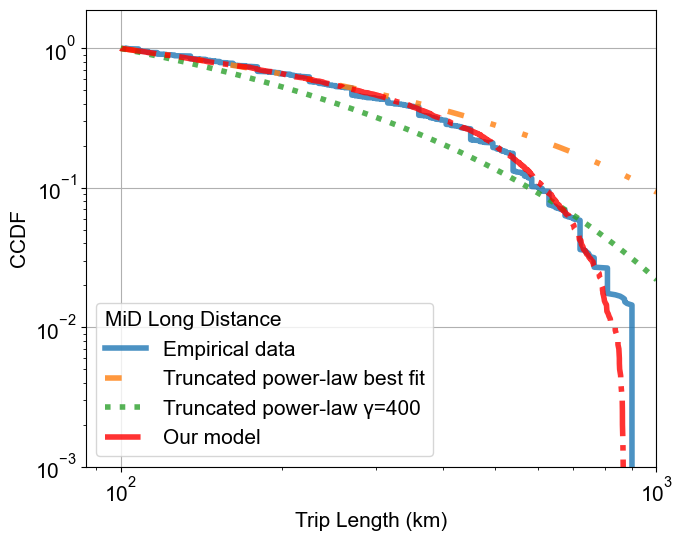

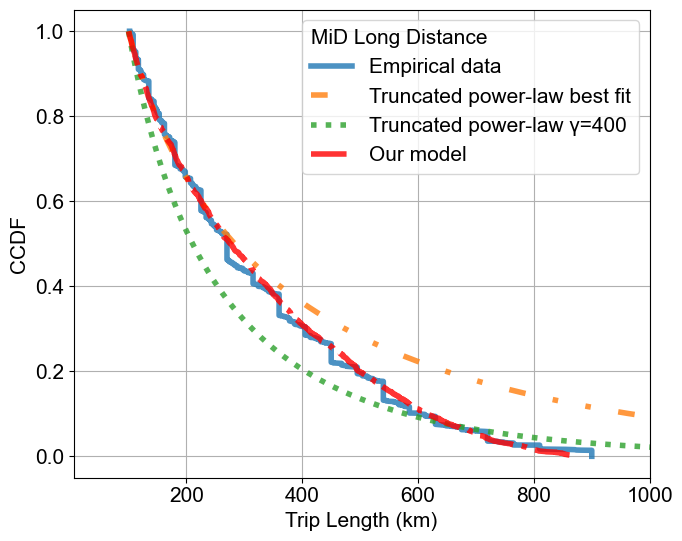

In [16]:
%%time
datalist=[df_vec,dist]
labels=['Empirical data','Our model']

Cs=[]
t=0
for alpha,gamma in zip(alphas,gammas):
    # compute C
    temp=0
    for d in Ds:
        temp+=funcD_noC(d,alpha,gamma)
    C=1/temp
    Cs.append(C)
custom_ccdf_draw_4lines(datalist,labels,Ds,Cs,alphas,gammas,normal=False)
custom_ccdf_draw_4lines(datalist,labels,Ds,Cs,alphas,gammas,normal=True)

## NHTS 2017

In [29]:
'''
 CCDF plots for NHTS data
 normal=True means the CCDF is a normal CCDF plot, otherwise it will plot the CCDF with log-scale
'''
def custom_ccdf_draw_4lines(datalist,labels,Ds,Cs,alphas,gammas,normal=True):
#     fig, ax = plt.subplots(figsize=(10,8))
    fig, ax = plt.subplots(figsize=(3.54*2,2.83*2))
    colors=['#1f77b4','red']
    linestyles=['solid','dashdot']
    for i,data in enumerate(datalist):
        if i==0:
            sorted_data = np.sort(data)
            linspaced = np.linspace(0, 1, len(data), endpoint=False)
            ax.plot(sorted_data, 1-linspaced,label=labels[i],color=colors[i],linestyle=linestyles[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)
#         ax.plot(sorted_data, 1-linspaced,label=labels[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)

    #the final results
    for C,alpha,gamma in zip(Cs,alphas,gammas):
        Fd=[0]*len(Ds)
        for idx,d in enumerate(Ds):
            for i in Ds[Ds>=d]:
                Fd[idx]+=funcD(C,i,alpha,gamma)
        if gamma==gammas[0]:
            ax.plot(Ds,Fd,label='Truncated power-law best fit',color='#ff7f0e',linestyle=(0,(3,5,1,5,1,5)),rasterized=False,markersize=5,alpha=0.8,linewidth=4)
        else:
            ax.plot(Ds,Fd,label='Truncated power-law γ=%d'%(gamma),color='#2ca02c',linestyle='dotted',rasterized=False,markersize=5,alpha=0.8,linewidth=4)

        empircal_data=datalist[0].tolist()
        # normalize the empircal data to make it can be compared with Fd, since the value of Fd always smaller than 1
        normalized_empircal=NormalizeData(empircal_data).tolist()
        e=custom_distance(Fd,normalized_empircal)
    for i,data in enumerate(datalist):
        if i==1:
            sorted_data = np.sort(data)
            linspaced = np.linspace(0, 1, len(data), endpoint=False)
            ax.plot(sorted_data, 1-linspaced,label=labels[i],color=colors[i],linestyle=linestyles[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)

    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    if normal:
        leg = ax.legend(title='NHTS Long Distance',loc='upper right',alignment='left')
        leg.get_title().set_fontsize('15')
        plt.xlim(right=5e+3)
        plt.grid()
        plt.tight_layout()
        plt.savefig(res+'CCDF_NHTS_LR_normal.pdf', dpi=100, bbox_inches='tight')
    else:
        plt.yscale("log")
        plt.xscale("log")
        leg = ax.legend(title='NHTS Long Distance',loc='lower left',alignment='left')
        leg.get_title().set_fontsize('15')
        plt.ylim(bottom=1e-03)
        plt.xlim(right=5e+3) 
        plt.grid()
        plt.tight_layout()
        plt.savefig(res+'CCDF_NHTS_LR_log.pdf', dpi=100, bbox_inches='tight')


In [30]:
'''
data and optimal parameters reading from the stored files
You can find them in the folder "results_mobility"
'''
# NHTS dataset reading
df_vec=df_Nhts_LRpublic.copy() # Long distance in NHTS 2017
min_distance=300
max_distance=5000
df_vec=df_vec[df_vec.between(min_distance,max_distance)]

# Reading the stored optimal modelling results from file (which can be got from above Modelling part as well)
opt_model=pd.read_pickle(res+'Optimal results of LR modelling in NHTS17.pkl')
optM=np.array(opt_model)
#Optimal result, which error is the lowest
eps = optM[0,0]
p = optM[1,0]
alp = optM[2,0]
dist= optM[4,0] #optimal trips list

# Reading the stored optimal truncated power-law fitting parameters
opt_trunc=pd.read_pickle(res+'Optimal truncated power-law in NHTS.pkl')
# one parameter is optimal alpha and gamma, the other one is handpicked alpha and gamma
alphas=[opt_trunc.alpha,1.02]
gammas=[opt_trunc.gamma,1400]
Ds=np.arange(300,12001,10) #distance trips setted

CPU times: total: 8.88 s
Wall time: 9.16 s


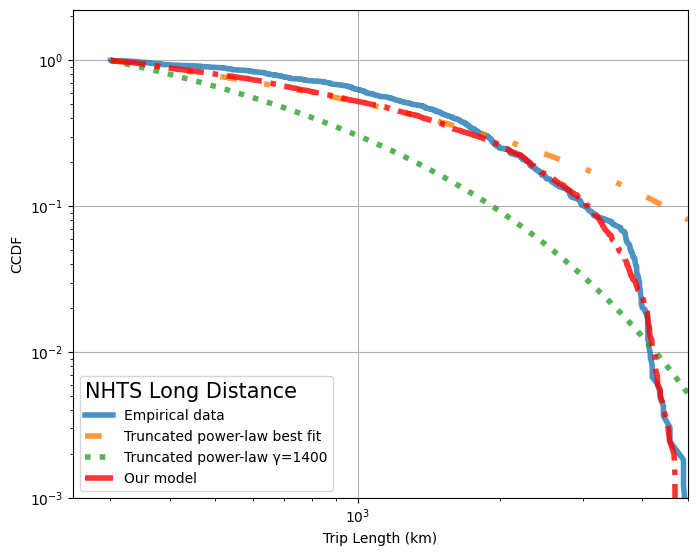

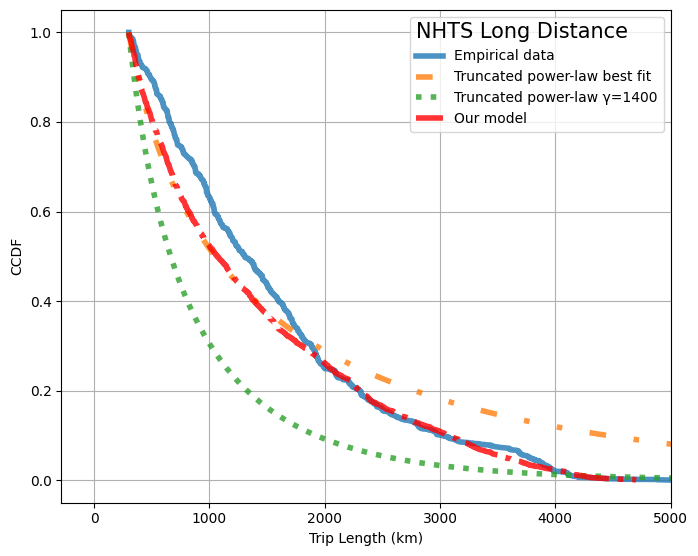

In [31]:
%%time
datalist=[df_vec,dist]
labels=['Empirical data','Our model']

Cs=[]
t=0
for alpha,gamma in zip(alphas,gammas):
    # compute C
    temp=0
    for d in Ds:
        temp+=funcD_noC(d,alpha,gamma)
    C=1/temp
    Cs.append(C)
custom_ccdf_draw_4lines(datalist,labels,Ds,Cs,alphas,gammas,normal=False)
custom_ccdf_draw_4lines(datalist,labels,Ds,Cs,alphas,gammas,normal=True)